In [1]:
# import libraries
# import nltk
# nltk.download('wordnet')

import pandas as pd 
import numpy as np
import pickle

from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### load and clean the dataset 

In [2]:
data_ori = pd.read_pickle(r'Bitcoin_tweets.pkl')

In [3]:
data_ori = data_ori.sample(20000)
data_ori.reset_index(drop=True,inplace=True)

In [4]:
data_ori.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,Br⚾️xim⚾️,toronto,(╯°□°)╯︵ ┻━┻,2011-06-12 04:26:40,108.0,479.0,6891.0,False,2021-07-03 19:51:16,I found #bitcoin in a User vault at this locat...,"['bitcoin', 'coinhuntworld', 'cryptocurrency']",Twitter for iPhone,False
1,Iman husein,NaN,Good,2020-12-18 15:22:11,57.0,991.0,884.0,False,2021-07-03 12:51:52,@paybswap Hopefully this project is a success ...,"['Airdrops', 'Bitcoin', 'crypto', 'Blockchain'...",Twitter Web App,False
2,ROGER 9000 🌞🐉🌋☯️💱🇸🇻,"London, England",fix the money 💵 fix the world🌎🙏❤️🌞#bitcoin fix...,2012-02-29 10:55:47,440.0,663.0,1071.0,False,2021-08-25 04:44:25,#BITCOIN = TRUTH \n\nTRUTH = TRUST \n\nTRUST...,['BITCOIN'],Twitter for iPhone,False
3,Luis Ramos,España,NaN,2011-08-27 07:26:57,114.0,49.0,750.0,False,2021-07-30 17:42:46,@CryptoK56985447 @BabyCakeBSC @PancakeSwap Bes...,"['BabyCake', 'btc', 'bnb', 'bitcoin', 'Binance...",Twitter Web App,False
4,Cryptzo Official,United States,One Stop Hub for all your crypto needs,2021-07-27 05:27:42,247.0,0.0,3.0,False,2021-08-16 07:00:00,https://t.co/wM6E4MUJPR\nSeasoned investors ar...,"['defi', 'cryptzo', 'yieldfarming', 'bitcoin',...",Twitter Web App,False


In [5]:
#clean the dataframe, drop the rows where the "text" and 'hashtags' columns are NaN
data_clean = data_ori.dropna(subset=['text','hashtags']).reset_index(drop=True)

In [6]:
# get only texts
text_data = data_clean[['text']].copy() 
text_data.columns = ['tweets']
# show the data
text_data.head()

,tweets
0,I found #bitcoin in a User vault at this locat...
1,@paybswap Hopefully this project is a success ...
2,#BITCOIN = TRUTH \n\nTRUTH = TRUST \n\nTRUST...
3,@CryptoK56985447 @BabyCakeBSC @PancakeSwap Bes...
4,https://t.co/wM6E4MUJPR\nSeasoned investors ar...


In [7]:
lemmatizer = WordNetLemmatizer()
# Import nltk stopwords and customize it to add common crypto words that don't add too much information 
stop_words = stopwords.words(['english'])
crypto_words = ['btc','bitcoin','eth','etherum','crypto']
stop_words = stop_words + crypto_words

In [8]:
# create a function to clean the tweets
def text_clean(data):
  #I.  
  #1. Remove urls/hyperlinks
  tweet_without_url = re.sub(r'((www\.[^\s]+)|(http\S+))',' ', data)

  #2. Remove hashtags
  tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

  #3. Remove mentions 
  tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)

  #4. Remove characters that not in the English alphabets
  tweet_pre_cleaned = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)
  
  #5. Remove additional white spaces
  tweet_pre_cleaned = re.sub('[\s]+', ' ', tweet_pre_cleaned)
    
  #II. 
    #1. Tokenize
  tweet_tokens = TweetTokenizer().tokenize(tweet_pre_cleaned)

    #2. Lower?
  tweet_lower = [l.lower() for l in tweet_tokens]

    #2. Remove Puncs
  tokens_without_punc = [w for w in tweet_lower if w.isalpha()]
    
    #3. Removing Stopwords
  lemmatizer = WordNetLemmatizer()
    # Import nltk stopwords and customize it to add common crypto words that don't add too much information 
  stop_words = stopwords.words(['english'])
  crypto_words = ['btc','bitcoin','eth','etherum','crypto']
  stop_words = stop_words + crypto_words
  tokens_without_stopwords = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. lemmatize
  text_cleaned = [lemmatizer.lemmatize(t) for t in tokens_without_stopwords]
    
    #5. Joining
  return " ".join(text_cleaned)

In [9]:
# create a column to store the clean tweets
text_data['cleaned_tweets'] = text_data['tweets'].apply(text_clean)

### using textblob to do sentiment analysis 

In [10]:
# using textblob to do sentiment analysis 
from textblob import TextBlob

# create a function to get subjectivity
# subjectivity is in range [0,1]
def getSubjectivity(tweet):
  return TextBlob(tweet).sentiment.subjectivity

# create a function to get the polarity
# polarity is in range [-1,1]
def getPolarity(tweet):
  return TextBlob(tweet).sentiment.polarity

# create a function to get sentiment text based on polarity
def getSentiment(score):
  if score < 0:
    return 'negative'
  elif score == 0:
    return 'neutral'
  else:
    return 'positive'

In [11]:
# create two new columns called "Subjectivity" & "Polarity"
text_data['subjectivity'] = text_data['cleaned_tweets'].apply(getSubjectivity)
text_data['polarity'] = text_data['cleaned_tweets'].apply(getPolarity)

In [12]:
# create a column to store the text sentiment
text_data['sentiment'] = text_data['polarity'].apply(getSentiment)

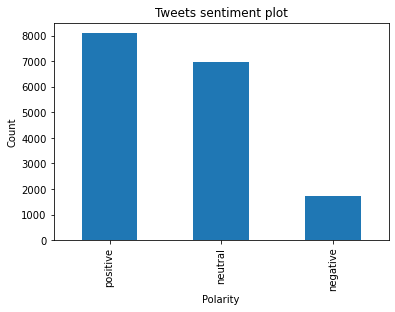

In [13]:
# bar plot of sentiment 
text_data['sentiment'].value_counts().plot(kind="bar")
plt.title("Tweets sentiment plot")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.show()

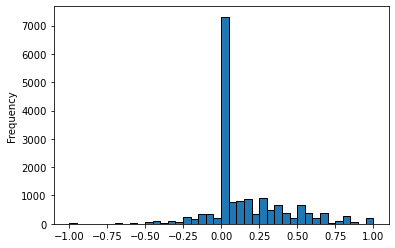

In [14]:
# histogram of polarity score
text_data.polarity.plot(kind='hist',range=(-1,1),bins=40,edgecolor='black');

In [15]:
text_data

,tweets,cleaned_tweets,subjectivity,polarity,sentiment
0,I found #bitcoin in a User vault at this locat...,found user vault location join playing awesome,1.000000,1.000000,positive
1,@paybswap Hopefully this project is a success ...,hopefully project success becomes one best cry...,0.410000,0.570000,positive
2,#BITCOIN = TRUTH \n\nTRUTH = TRUST \n\nTRUST...,truth truth trust trust love,0.600000,0.500000,positive
3,@CryptoK56985447 @BabyCakeBSC @PancakeSwap Bes...,best token bsc,0.300000,1.000000,positive
4,https://t.co/wM6E4MUJPR\nSeasoned investors ar...,seasoned investor increasingly active data hin...,0.403333,0.143333,positive
...,...,...,...,...,...
16813,#business #businessgoals #businessgrowth #busi...,get paid using webtalk,0.000000,0.000000,neutral
16814,We all make mistakes in life👊\n\nAlways keep l...,make mistake life always keep learning somethi...,0.451515,-0.126768,negative
16815,Want in on #Bitcoin but too nervous to buy? \n...,want nervous buy shop get cashback instead brand,0.000000,0.000000,neutral
16816,@ialihamza91 Elon you going to wait another 10...,elon going wait another year look best best,0.300000,1.000000,positive


In [16]:
# combine the original dataset with sentiment score
data_combine = pd.concat([data_clean[['date','user_name','user_followers','user_friends']], text_data],axis=1)

In [54]:
# show the data
data_combine.head(5)

,date,user_name,user_followers,user_friends,tweets,cleaned_tweets,subjectivity,polarity,sentiment
0,2021-07-03 19:51:16,Br⚾️xim⚾️,108.0,479.0,I found #bitcoin in a User vault at this locat...,found user vault location join playing awesome,1.00,1.00,positive
1,2021-07-03 12:51:52,Iman husein,57.0,991.0,@paybswap Hopefully this project is a success ...,hopefully project success becomes one best cry...,0.41,0.57,positive
2,2021-08-25 04:44:25,ROGER 9000 🌞🐉🌋☯️💱🇸🇻,440.0,663.0,#BITCOIN = TRUTH \n\nTRUTH = TRUST \n\nTRUST...,truth truth trust trust love,0.60,0.50,positive


### prepare_train_and_test_dataset

In [55]:
from sklearn.model_selection import train_test_split
tfidf = TfidfVectorizer(analyzer='word')
X_raw = data_combine['cleaned_tweets']
y_raw = data_combine['sentiment']
X_tfidf = tfidf.fit_transform(X_raw)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_raw, test_size=0.2, random_state=42)

## convert the text data into matrix 
### use RandomForestClassifier to test vectorizer performance

### 1. use tfidf vectorizer 

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word')
X_raw = data_combine['cleaned_tweets']
y_raw = data_combine['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

In [57]:
X_tfidf_train = tfidf.fit_transform(X_train)

In [58]:
from sklearn.ensemble import RandomForestClassifier
# instantiate the clf model
clf = RandomForestClassifier(random_state=42)
# train the model
clf.fit(X_tfidf_train, y_train)

# transform the X_test
X_test_transformed = tfidf.transform(X_test)

# validation
predicted2 = clf.predict(X_test_transformed)

In [59]:
accuracy_score2 = accuracy_score(y_test, predicted2)
accuracy_score2
# 0.9232377538829152

0.9289536266349584

### 2. use countvectorizer

In [60]:
# instantiate the vectorizer object
countvectorizer = CountVectorizer(analyzer='word', stop_words='english')
# convert the documents into a matrix
final_count_train = countvectorizer.fit_transform(X_train)

# instantiate the clf model
clf2 = RandomForestClassifier(random_state=42)
# train the model
clf2.fit(final_count_train, y_train)

# transform the X_test
X_test_trans_C = countvectorizer.transform(X_test)

# validation
predicted1 = clf2.predict(X_test_trans_C)
accuracy_score1 = accuracy_score(y_test, predicted1)
accuracy_score1
# 0.9032258064516129

0.9114149821640903

### 3. hashing vectorizer

In [61]:
# instantiate the vectorizer object
hash_vectorizer = HashingVectorizer(analyzer='word', stop_words='english')
# convert the documents into a matrix
final_hash_train = hash_vectorizer.fit_transform(X_train)

# instantiate the clf model
clf3 = RandomForestClassifier(random_state=42)
# train the model
clf3.fit(final_hash_train, y_train)

# transform the X_test
X_test_trans_hash = hash_vectorizer.transform(X_test)

# validation
predicted3 = clf3.predict(X_test_trans_hash)
accuracy_score3 = accuracy_score(y_test, predicted3)
accuracy_score3
# 0.8623058542413381

0.879013079667063

## test different classifier models 

### using SGDClassifier model

In [62]:
# SGDClassifier model
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(random_state=42)
model.fit(X_tfidf_train, y_train)

# transform the X_test
X_test_transformed = tfidf.transform(X_test)
# validation
pred1 = model.predict(X_test_transformed)

accuracy_s1 = accuracy_score(y_test, pred1)
accuracy_s1

0.9078478002378121

### using MultinomialNB model

In [26]:
# MultinomialNB model
from sklearn.naive_bayes import MultinomialNB
model2 = MultinomialNB()
model2.fit(X_tfidf_train, y_train)
# transform the X_test
X_test_transformed = tfidf.transform(X_test)
# validation
pred2 = model2.predict(X_test_transformed)
accuracy_s2 = accuracy_score(y_test, pred2)
accuracy_s2

0.7517835909631391

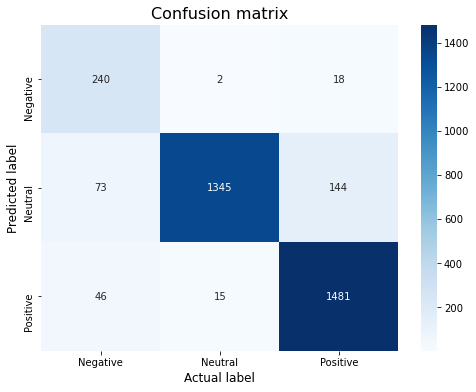

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_pred, y_test):
    sentiment_classes = ['Negative','Neutral', 'Positive']
    cm = confusion_matrix(y_pred,y_test)    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(predicted1, y_test)

## future work: using tensorflow

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

In [31]:
print('Before Tokenization & Padding \n', data_combine['cleaned_tweets'][0])
X, tokenizer = tokenize_pad_sequences(data_combine['cleaned_tweets'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 found user vault location join playing awesome
After Tokenization & Padding 
 [231 123 254 262  14 204 137   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [32]:
y = pd.get_dummies(data_combine['sentiment'])
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (10090, 50) (10090, 3)
Validation Set:  (3364, 50) (3364, 3)
Test Set:  (3364, 50) (3364, 3)


In [33]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [35]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [36]:
sgd = RMSprop()
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [37]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',Precision(), Recall()])

In [38]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

Epoch 1/10
158/158 [==============================] - 14s 36ms/step - loss: 0.7264 - accuracy: 0.6975 - precision: 0.7688 - recall: 0.5682 - val_loss: 0.5149 - val_accuracy: 0.8008 - val_precision: 0.8347 - val_recall: 0.7610
Epoch 2/10
158/158 [==============================] - 3s 21ms/step - loss: 0.3683 - accuracy: 0.8666 - precision: 0.9041 - recall: 0.8353 - val_loss: 0.4321 - val_accuracy: 0.8487 - val_precision: 0.8789 - val_recall: 0.8130
Epoch 3/10
158/158 [==============================] - 4s 24ms/step - loss: 0.2672 - accuracy: 0.9069 - precision: 0.9366 - recall: 0.8723 - val_loss: 0.3900 - val_accuracy: 0.8540 - val_precision: 0.8749 - val_recall: 0.8356
Epoch 4/10
158/158 [==============================] - 4s 23ms/step - loss: 0.2178 - accuracy: 0.9299 - precision: 0.9415 - recall: 0.9191 - val_loss: 0.4211 - val_accuracy: 0.8618 - val_precision: 0.8862 - val_recall: 0.8448
Epoch 5/10
158/158 [==============================] - 5s 31ms/step - loss: 0.1735 - accuracy: 0.946

In [39]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9058
Precision : 0.9102
Recall    : 0.9034
F1 Score  : 0.9068


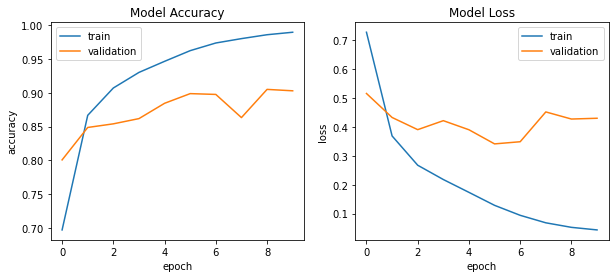

In [40]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

2    1643
1    1362
0     359
dtype: int64
2    1717
1    1257
0     390
dtype: int64


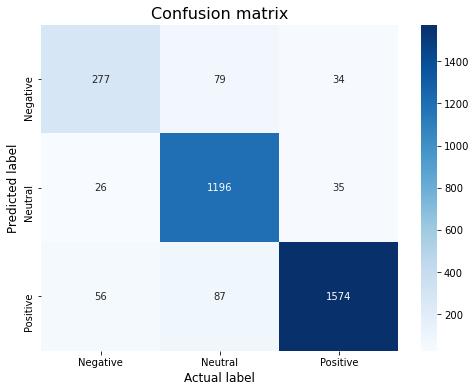

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [51]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

    negative       1.00      0.09      0.17       359
     neutral       0.85      0.69      0.76      1362
    positive       0.71      0.96      0.81      1643

    accuracy                           0.76      3364
   macro avg       0.85      0.58      0.58      3364
weighted avg       0.79      0.76      0.72      3364

